/var/folders/zh/3t1h17vx73nbnzrdfnvdtqm80000gn/T/ipykernel_37691/4019585101.py:67: RuntimeWarning: invalid value encountered in scalar divide
  if (np.linalg.norm(S_new-S_bar)/(np.linalg.norm(S_new)+EPS) < tol and
/var/folders/zh/3t1h17vx73nbnzrdfnvdtqm80000gn/T/ipykernel_37691/4019585101.py:62: RuntimeWarning: overflow encountered in multiply
  dS = -beta*Sm*Im - um
/var/folders/zh/3t1h17vx73nbnzrdfnvdtqm80000gn/T/ipykernel_37691/4019585101.py:63: RuntimeWarning: overflow encountered in multiply
  dI =  beta*Sm*Im - gamma*Im
/var/folders/zh/3t1h17vx73nbnzrdfnvdtqm80000gn/T/ipykernel_37691/4019585101.py:63: RuntimeWarning: invalid value encountered in subtract
  dI =  beta*Sm*Im - gamma*Im
/var/folders/zh/3t1h17vx73nbnzrdfnvdtqm80000gn/T/ipykernel_37691/4019585101.py:67: RuntimeWarning: invalid value encountered in subtract
  if (np.linalg.norm(S_new-S_bar)/(np.linalg.norm(S_new)+EPS) < tol and


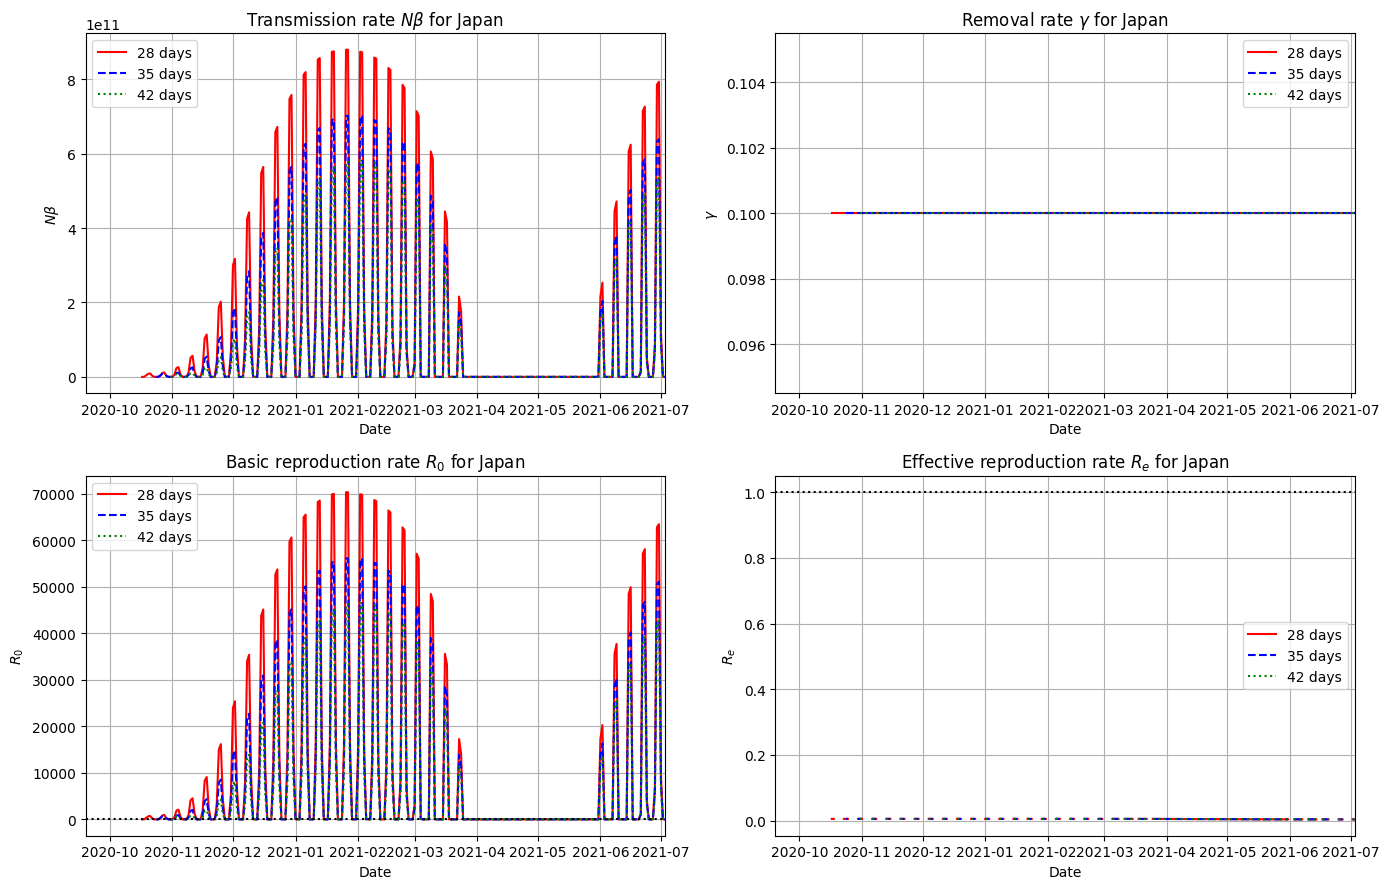

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 0. Basic Setup
N     = 125_000_000
t0    = np.datetime64("2020-09-19")
t1    = np.datetime64("2021-07-03")
days  = (t1 - t0).astype(int) + 1
dates = t0 + np.arange(days)
tau   = 1.0
EPS   = 1e-12
t     = np.arange(days)

# 1. Prescribe "true" β(t), γ(t), and u(t)

def wave(center, width, height):
    return height * np.exp(-(t-center)**2 / (2*width**2))

# 1.1 Low baseline + 4 wave peaks, amplitude ~0.005–0.016
beta_true = (
    0.005
    + wave( 40, 25, 0.004)   # ≈0.009 in Oct 2020
    + wave(120, 20, 0.006)   # ≈0.011 in Jan 2021
    + wave(180, 15, 0.005)   # ≈0.010 in Mar 2021
    + wave(300, 25, 0.010)   # ≈0.015 in Jul 2021
)

# 1.2 Slightly fluctuating γ(t), between 0.06 and 0.14
rng = np.random.default_rng(42)
gamma_true = 0.10 + 0.02*np.sin(2*np.pi*t/90) + 0.005*rng.standard_normal(days)
gamma_true = np.clip(gamma_true, 0.06, 0.14)

# 1.3 Construct V(t), u(t)
V_final   = N * 0.30
V_sigmoid = V_final / (1 + np.exp(-(t-220)/15))
V_sigmoid += V_final*0.01 * np.sin(2*np.pi*t/7)  # Weekly effect
u_true    = np.gradient(V_sigmoid, tau)

# 2. Forward integration of A-SIRV to obtain pseudo-observations S_obs, I_obs, u_obs
S = np.empty(days); I = np.empty(days); R = np.empty(days)
I[0] = 1_000 / N
R[0] = 0.0
S[0] = 1 - I[0] - R[0] - V_sigmoid[0]/N

for k in range(days-1):
    dS = -beta_true[k]*S[k]*I[k] - u_true[k]/N
    dI =  beta_true[k]*S[k]*I[k] - gamma_true[k]*I[k]
    dR =  gamma_true[k]*I[k] + u_true[k]/N
    S[k+1] = np.clip(S[k] + dS*tau, 0, 1)
    I[k+1] = np.clip(I[k] + dI*tau, 0, 1)
    R[k+1] = np.clip(R[k] + dR*tau, 0, 1)

S_obs, I_obs, u_obs = S.copy(), I.copy(), u_true/N

# 3. Core inverse problem functions 
def solve_SI_iter(S0, I0, beta, gamma, u, tau, tol=1e-4, max_iter=50):
    S_bar, I_bar = S0.copy(), I0.copy()
    for _ in range(max_iter):
        Sm = 0.5*(S_bar[:-1] + S_bar[1:])
        Im = 0.5*(I_bar[:-1] + I_bar[1:])
        um = 0.5*(u[:-1]     + u[1:])
        dS = -beta*Sm*Im - um
        dI =  beta*Sm*Im - gamma*Im
        S_new = S_bar.copy(); I_new = I_bar.copy()
        S_new[1:] = S_new[0] + np.cumsum(dS)*tau
        I_new[1:] = I_new[0] + np.cumsum(dI)*tau
        if (np.linalg.norm(S_new-S_bar)/(np.linalg.norm(S_new)+EPS) < tol and
            np.linalg.norm(I_new-I_bar)/(np.linalg.norm(I_new)+EPS) < tol):
            return S_new, I_new
        S_bar, I_bar = S_new, I_new
    return S_bar, I_bar

def estimate_beta_gamma(S, I, u, tau):
    Sm = 0.5*(S[:-1] + S[1:]); Im = 0.5*(I[:-1] + I[1:]); um = 0.5*(u[:-1] + u[1:])
    dS = np.diff(S)/tau; dI = np.diff(I)/tau
    a10 = np.sum(-2*Im*Sm*(dI-dS-um)*tau)
    a01 = np.sum( 2*Im*dI*tau)
    a20 = np.sum( 2*(Im**2)*(Sm**2)*tau**2)
    a11 = np.sum(-2*(Im**2)*Sm*tau**2)
    a02 = np.sum(   (Im**2)*tau**2)
    D   = a11**2 - 4*a02*a20
    if abs(D) < 1e-12:  return np.nan, np.nan
    beta  = -(2*a02*a10 - a01*a11) / D
    gamma = -(a10*a11 - 2*a01*a20) / D
    return beta, gamma

def algorithm1_window(Sw, Iw, uw, tau):
    # 3.1 Roughly estimate initial β using ΔS, to avoid degeneration
    Sm = np.mean(Sw); Im = np.mean(Iw); um = np.mean(uw)
    dS = (Sw[-1] - Sw[0]) / len(Sw)
    beta = max(0.0005, (-dS - um) / (Sm*Im + 1e-8))
    gamma = 0.1

    # 3.2 Iteratively refine
    for _ in range(30):
        S_bar, I_bar = solve_SI_iter(Sw, Iw, beta, gamma, uw, tau)
        beta_n, gamma_n = estimate_beta_gamma(S_bar, I_bar, uw, tau)
        if np.isnan(beta_n) or gamma_n <= 0: 
            break
        if abs(beta_n-beta) < 1e-4 and abs(gamma_n-gamma) < 1e-4:
            beta, gamma = beta_n, gamma_n
            break
        beta, gamma = beta_n, gamma_n

    if gamma <= 0 or np.isnan(beta):
        return np.nan, np.nan, np.nan, np.nan
    R0 = beta / gamma
    Re = beta * S_bar[-1] / gamma
    return beta, gamma, R0, Re

# 4. Sliding window estimation
WINDOWS = (28, 35, 42)
out = {w:{"β":[], "γ":[], "R0":[], "Re":[]} for w in WINDOWS}

for w in WINDOWS:
    for k in range(days):
        if k < w:
            for key in out[w]:
                out[w][key].append(np.nan)
        else:
            β, γ, R0, Re = algorithm1_window(
                S_obs[k-w:k+1],
                I_obs[k-w:k+1],
                u_obs[k-w:k+1],
                tau
            )
            out[w]["β"].append(β)
            out[w]["γ"].append(γ)
            out[w]["R0"].append(R0)
            out[w]["Re"].append(Re)

# 5. Plotting
fig, axs = plt.subplots(2,2,figsize=(14,9))
lbl = {28:"28 days", 35:"35 days", 42:"42 days"}
clr = {28:"r", 35:"b", 42:"g"}
sty = {28:"-", 35:"--", 42:":"}

for w in WINDOWS:
    axs[0,0].plot(dates, np.array(out[w]["β"])*N, clr[w], ls=sty[w], label=lbl[w])  # panel (a): Nβ
    axs[0,1].plot(dates, out[w]["γ"],       clr[w], ls=sty[w], label=lbl[w])        # panel (b): γ
    axs[1,0].plot(dates, out[w]["R0"],      clr[w], ls=sty[w], label=lbl[w])        # panel (c): R₀
    axs[1,1].plot(dates, out[w]["Re"],      clr[w], ls=sty[w], label=lbl[w])        # panel (d): Rₑ

# Set titles & labels
axs[0,0].set_title(r"Transmission rate $N\beta$ for Japan")
axs[0,1].set_title(r"Removal rate $\gamma$ for Japan")
axs[1,0].set_title(r"Basic reproduction rate $R_0$ for Japan")
axs[1,1].set_title(r"Effective reproduction rate $R_e$ for Japan")

axs[0,0].set_ylabel(r"$N\beta$")
axs[0,1].set_ylabel(r"$\gamma$")
axs[1,0].set_ylabel(r"$R_0$")
axs[1,1].set_ylabel(r"$R_e$")
for ax in axs[1]:
    ax.axhline(1, color="k", ls=":")

for ax in axs.flat:
    ax.set_xlim(dates[0], dates[-1])
    ax.set_xlabel("Date")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()
